# **Previsão básica de ações utilizando Multi Layer Perceptron**

- Diogo Nunes Batista

### Carregamento dos dados

In [18]:
import pandas
import numpy as np

df_stocks_types = {
    'ABERTURA': np.float64,
    'FECHAMENTO': np.float64,
    'VARIAÇÃO': np.float64,
    'MÍNIMO': np.float64,
    'MÁXIMO': np.float64,
    'VOLUME': str
}

df_selic_types = {
    'valor': np.float64,
}

df_stocks = pandas.read_csv('IRB_Brasil_RE_IRBR3.csv', index_col="DATA" , dtype=df_stocks_types, decimal=',')

df_selic = pandas.read_csv('selic.csv', sep=';', index_col="data",  dtype=df_selic_types , decimal=',')

print(f"df_stocks\n{df_stocks}\n\ndf_selic\n{df_selic}")

df_stocks
            ABERTURA  FECHAMENTO  VARIAÇÃO  MÍNIMO  MÁXIMO   VOLUME
DATA                                                               
25/10/2024     44.66       41.35     -6.49   41.32   44.95   99,31M
24/10/2024     47.91       44.22     -7.32   44.22   48.45  126,76M
23/10/2024     42.80       47.71     12.29   42.68   48.15  153,65M
22/10/2024     42.45       42.49      0.07   41.59   42.53   25,37M
21/10/2024     41.86       42.46      1.94   41.61   42.56   28,14M
...              ...         ...       ...     ...     ...      ...
02/05/2024     43.37       43.75      2.99   43.19   44.78   90,85M
30/04/2024     42.98       42.48     -1.26   42.29   43.78   65,25M
29/04/2024     42.15       43.02      1.58   41.53   43.27   39,72M
26/04/2024     41.53       42.35      2.69   41.25   42.76   54,96M
25/04/2024     40.80       41.24      1.18   40.30   41.40   44,64M

[129 rows x 6 columns]

df_selic
               valor
data                
02/01/2024  0.043739
03/01/202

### Tratamento dos dados

In [19]:
df_selic.rename(columns={'valor': 'SELIC'}, inplace=True)
df_selic['SELIC'] = df_selic['SELIC']

df_stocks['VOLUME'] = df_stocks['VOLUME'].str.replace('M', '').str.replace(',', '.').astype(np.float64) # Remove 'M' e subtitui ',' por '.' o que possibilita a conversão para float

df = df_stocks.join(df_selic, how='inner') # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html

dates = df.index.str.split('/')
df['DIA'] = dates.str[0].astype(np.float64)
df['MÊS'] = dates.str[1].astype(np.float64)

df = df.iloc[::-1]

print(df)

            ABERTURA  FECHAMENTO  VARIAÇÃO  MÍNIMO  MÁXIMO  VOLUME     SELIC  \
25/04/2024     40.80       41.24      1.18   40.30   41.40   44.64  0.040168   
26/04/2024     41.53       42.35      2.69   41.25   42.76   54.96  0.040168   
29/04/2024     42.15       43.02      1.58   41.53   43.27   39.72  0.040168   
30/04/2024     42.98       42.48     -1.26   42.29   43.78   65.25  0.040168   
02/05/2024     43.37       43.75      2.99   43.19   44.78   90.85  0.040168   
...              ...         ...       ...     ...     ...     ...       ...   
21/10/2024     41.86       42.46      1.94   41.61   42.56   28.14  0.040168   
22/10/2024     42.45       42.49      0.07   41.59   42.53   25.37  0.040168   
23/10/2024     42.80       47.71     12.29   42.68   48.15  153.65  0.040168   
24/10/2024     47.91       44.22     -7.32   44.22   48.45  126.76  0.040168   
25/10/2024     44.66       41.35     -6.49   41.32   44.95   99.31  0.040168   

             DIA   MÊS  
25/04/2024  25

### Plotando

C:\Users\Diogo\AppData\Local\Temp\ipykernel_6760\2736737018.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.get_figure().show()


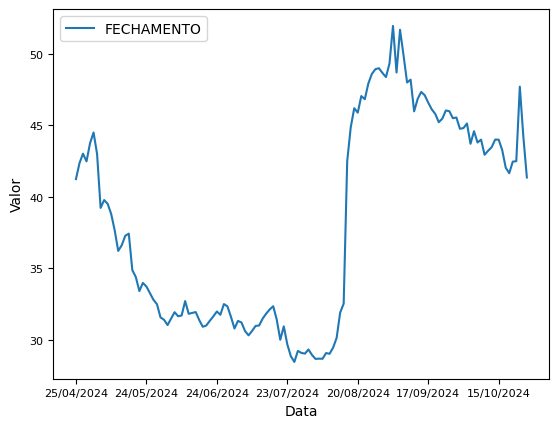

In [20]:
ax = df.plot(y='FECHAMENTO', xlabel='Data', ylabel='Valor', fontsize=8)
ax.get_figure().show()

### Separação input e target

In [21]:
df['FECHAMENTO D+1'] = df['FECHAMENTO'].shift(-1)
df.dropna(inplace=True)

n_test = 7 + 1 

df_test = df.tail(n_test)
df_train = df.drop(df_test.index)

x = df_train[['FECHAMENTO', 'SELIC', 'DIA', 'MÊS']]
t = df_train[['FECHAMENTO D+1']]

x_test = df_test[['FECHAMENTO', 'SELIC', 'DIA', 'MÊS']]
t_test = df_test[['FECHAMENTO D+1']]

print(x)
print(t)

            FECHAMENTO     SELIC   DIA   MÊS
25/04/2024       41.24  0.040168  25.0   4.0
26/04/2024       42.35  0.040168  26.0   4.0
29/04/2024       43.02  0.040168  29.0   4.0
30/04/2024       42.48  0.040168  30.0   4.0
02/05/2024       43.75  0.040168   2.0   5.0
...                ...       ...   ...   ...
08/10/2024       44.00  0.040168   8.0  10.0
09/10/2024       42.94  0.040168   9.0  10.0
10/10/2024       43.22  0.040168  10.0  10.0
11/10/2024       43.47  0.040168  11.0  10.0
14/10/2024       44.00  0.040168  14.0  10.0

[120 rows x 4 columns]
            FECHAMENTO D+1
25/04/2024           42.35
26/04/2024           43.02
29/04/2024           42.48
30/04/2024           43.75
02/05/2024           44.50
...                    ...
08/10/2024           42.94
09/10/2024           43.22
10/10/2024           43.47
11/10/2024           44.00
14/10/2024           44.00

[120 rows x 1 columns]


### Normalização

In [22]:
t.iloc[:,0] = t.iloc[:,0] / 100.0 # y['FECHAMENTO D+1'] = y['FECHAMENTO D+1'] / 100.0
x.iloc[:,0] = x.iloc[:,0] / 100.0 # x['FECHAMENTO'] = x['FECHAMENTO'] / 100.0
x.iloc[:,2] = x.iloc[:,2] / 31.0  # x['DIA'] = x['DIA'] / 31.0
x.iloc[:,3] = x.iloc[:,3] / 12.0  # x['MÊS'] = x['MÊS'] / 12.0

t_test.iloc[:,0] = t_test.iloc[:,0] / 100.0 # y['FECHAMENTO D+1'] = y['FECHAMENTO D+1'] / 100.0
x_test.iloc[:,0] = x_test.iloc[:,0] / 100.0 # x['FECHAMENTO'] = x['FECHAMENTO'] / 100.0
x_test.iloc[:,2] = x_test.iloc[:,2] / 31.0  # x['DIA'] = x['DIA'] / 31.0
x_test.iloc[:,3] = x_test.iloc[:,3] / 12.0  # x['MÊS'] = x['MÊS'] / 12.0

print('DF para treinamento')
print(x)
print(t)
print('DF para testes')
print(x_test)
print(t_test)

DF para treinamento
            FECHAMENTO     SELIC       DIA       MÊS
25/04/2024      0.4124  0.040168  0.806452  0.333333
26/04/2024      0.4235  0.040168  0.838710  0.333333
29/04/2024      0.4302  0.040168  0.935484  0.333333
30/04/2024      0.4248  0.040168  0.967742  0.333333
02/05/2024      0.4375  0.040168  0.064516  0.416667
...                ...       ...       ...       ...
08/10/2024      0.4400  0.040168  0.258065  0.833333
09/10/2024      0.4294  0.040168  0.290323  0.833333
10/10/2024      0.4322  0.040168  0.322581  0.833333
11/10/2024      0.4347  0.040168  0.354839  0.833333
14/10/2024      0.4400  0.040168  0.451613  0.833333

[120 rows x 4 columns]
            FECHAMENTO D+1
25/04/2024          0.4235
26/04/2024          0.4302
29/04/2024          0.4248
30/04/2024          0.4375
02/05/2024          0.4450
...                    ...
08/10/2024          0.4294
09/10/2024          0.4322
10/10/2024          0.4347
11/10/2024          0.4400
14/10/2024          0.4

### Teste

Error: 0.009865558719598483 - epochs: 10000
Entrada  [[0.44       0.040168   0.48387097 0.83333333]]
Saída  [[0.44687182 0.040168   0.51612903 0.83333333]]
Entrada  [[0.44687182 0.040168   0.51612903 0.83333333]]
Saída  [[0.4526397  0.040168   0.5483871  0.83333333]]
Entrada  [[0.4526397  0.040168   0.5483871  0.83333333]]
Saída  [[0.45742657 0.040168   0.58064516 0.83333333]]
Entrada  [[0.45742657 0.040168   0.58064516 0.83333333]]
Saída  [[0.46136472 0.040168   0.67741935 0.83333333]]
Entrada  [[0.46136472 0.040168   0.67741935 0.83333333]]
Saída  [[0.46479416 0.040168   0.70967742 0.83333333]]
Entrada  [[0.46479416 0.040168   0.70967742 0.83333333]]
Saída  [[0.46754031 0.040168   0.74193548 0.83333333]]
Entrada  [[0.46754031 0.040168   0.74193548 0.83333333]]
Saída  [[0.46972255 0.040168   0.77419355 0.83333333]]


C:\Users\Diogo\AppData\Local\Temp\ipykernel_6760\2511378410.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  df_train.plot(y=['FECHAMENTO', 'PREDIÇÃO'], xlabel='Data', ylabel='Valor', fontsize=8).get_figure().show()
C:\Users\Diogo\AppData\Local\Temp\ipykernel_6760\2511378410.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i+1,0] = mlp.predict(X[i:i+1])
C:\Users\Diogo\AppData\Local\Temp\ipykernel_6760\2511378410.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PREDIÇÃO'] = X[:,0] * 100.0
C:\Users\Diogo\AppData\Local\Temp

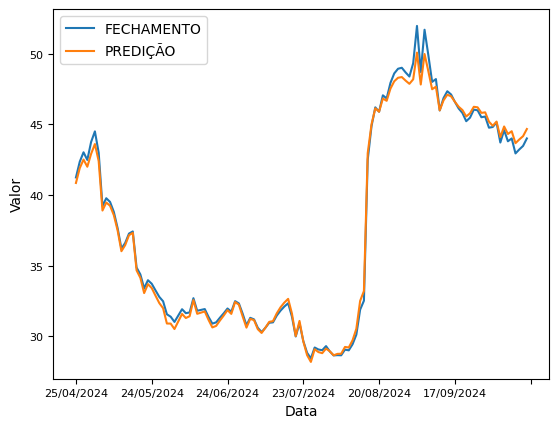

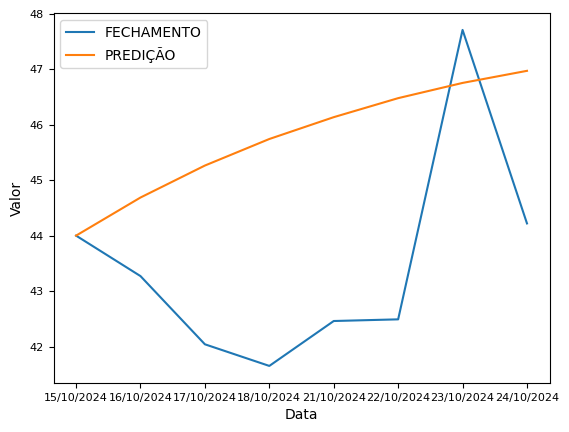

In [23]:
from mlp_model import MLP

mlp = MLP(layers_sizes=[4, 20, 20, 20, 20, 1])
error, epochs = mlp.train(x.to_numpy(), t.to_numpy(), learning_rate=0.03, max_epochs=10000, tolerated_error=0.001)
print(f'Error: {error} - epochs: {epochs}')

y = mlp.predict(x.to_numpy())

df_train['PREDIÇÃO'] = y * 100.0
df_train.plot(y=['FECHAMENTO', 'PREDIÇÃO'], xlabel='Data', ylabel='Valor', fontsize=8).get_figure().show()

X = x_test.to_numpy()
for i in range(0, n_test - 1):
    print("Entrada ", X[i:i+1])
    X[i+1,0] = mlp.predict(X[i:i+1])
    print("Saída ", X[i+1:i+2])

df_test['PREDIÇÃO'] = X[:,0] * 100.0
df_test.plot(y=['FECHAMENTO', 'PREDIÇÃO'], xlabel='Data', ylabel='Valor', fontsize=8).get_figure().show()